### Reccurent Neural Networks
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Movie Sentiment Analysis
    a. Dataset
    b. Data Preprocessing
    c. PyTorch RNN 
    d. Keras Simple Neural Network 
    e. Keras Convolutional Neural Network
    f. Lab Task
```

<hr>


## Dataset Description

[IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/) having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. 

## Data Preprocessing

[`torchtext`](https://pytorch.org/text/stable/index.html) is a package that consists of data processing utilities and popular datasets for natural language

One of the main concepts of TorchText is the `Field`. To define how the data should be processed we will use `Field`. Our input data contains raw strings <br>
The declared `TEXT` field defines how the review should be processed, and the `LABEL` field to process the sentiment. 

For more on `Fields`, go [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).


In [1]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

## Download the data
The following code automatically downloads the IMDb dataset and splits it into the canonical train/test splits as `torchtext.datasets` objects. It process the data using the `Fields` we have previously defined. The IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review.

In [2]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

print(f'{len(train_data)} training examples')
print(f'{len(test_data)} testing examples')

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 62.2MB/s]


25000 training examples
25000 testing examples


## Split the data to train and validation 

In [3]:
import random
import seaborn as sns

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Again, we'll view how many examples are in each split.

In [4]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [5]:
MAX_VOCAB_SIZE = 25_000
import torchtext.vocab as vocab

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

LABEL.build_vocab(train_data)

Why do we only build the vocabulary on the training set? When testing any machine learning system you do not want to look at the test set in any way. We do not include the validation set as we want it to reflect the test set as much as possible.

In [6]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


## Dataloders / Iterators 

* We have done preprocessing of the raw data but we have to create batches and convert the data to tensors. For text data Pytorch provides a container called `BucketIterator` for such task.

* The `BucketIterator` will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

* To put the data into the training device, its neccesary to specify the device parameter in the `BucketIterator` then Pytorch will take care of the rest. 


In [8]:
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
    batch_size = batch_size,
    device = device)

## Build the Model

The next stage is building the model that we'll eventually train and evaluate. 

There is a small amount of boilerplate code when creating models in PyTorch, note how our `RNN` class is a sub-class of `nn.Module` and the use of `super`.

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer. All layers have their parameters initialized to random values, unless explicitly specified.



![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment7.png?raw=1)



In [9]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()
    
    self.embedding_layer = nn.Embedding(input_dim, embedding_dim)
    self.rnn_cell = nn.RNN(embedding_dim, hidden_dim)
    self.fc_layer = nn.Linear(hidden_dim, output_dim)
      
  def forward(self, text):
    """
    Foward pass
    Args:
        text:
            sentiment text with shape [sentence length, batch size]
    """
    embedded = self.embedding_layer(text) # embedding_layer output shape  (sentence length, batch size, embedding dim]
    output, hidden = self.rnn_cell(embedded) 
    
    assert torch.equal(output[-1,:,:], hidden.squeeze(0))
    
    return self.fc_layer(hidden.squeeze(0))

In [10]:
input_dim = len(TEXT.vocab) #input dimension is the dimension of the one-hot vectors
embedding_dim = 100
hidden_dim = 256 #size of the hidden states
output_dim = 1 # for the fully connected 

model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)

## Model Training

In [11]:
import torch.optim as optim

# define loss function and optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

#make model instance and send it to training device
model = model.to(device)
criterion = criterion.to(device)

In [12]:
# accuracy_calculator which takes predicted labels and real labels
def accuracy_calculator(preds, y):
  """Returns accuracy per batch"""
  rounded_preds = torch.round(torch.sigmoid(preds)) #round predictions to the closest integer
  correct = (rounded_preds == y).float()
  return correct.sum() / len(correct)

In [13]:
def train(model, iterator, optimizer, criterion):
  
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  
  for batch in iterator:

    optimizer.zero_grad()
    predictions = model(batch.text).squeeze(1)
    loss = criterion(predictions, batch.label)

    acc = accuracy_calculator(predictions, batch.label)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [14]:
def evaluate_model(model, data_batches, criterion):
  eval_loss = 0
  eval_acc = 0
  
  model.eval()
  
  with torch.no_grad():
    for batch in data_batches:
      predictions = model(batch.text).squeeze(1)
      loss = criterion(predictions, batch.label)
      
      acc = accuracy_calculator(predictions, batch.label)
      eval_loss += loss.item()
      eval_acc += acc.item()
  
  return eval_loss / len(data_batches), eval_acc / len(data_batches)


In [15]:
epochs = 5

best_valid_loss = float('inf')

for epoch in range(epochs):
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate_model(model, valid_iterator, criterion)
  
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best-model.pt')
    
    print(f'Epoch: {epoch+1} , Train [Loss:  {train_loss:.3f}  Acc :{train_acc*100:.2f}], Val.[Loss: {valid_loss:.3f} Acc: {valid_acc*100:.2f}]')

Epoch: 1 , Train [Loss:  0.694  Acc :50.18], Val.[Loss: 0.696 Acc: 50.87]
Epoch: 2 , Train [Loss:  0.693  Acc :49.62], Val.[Loss: 0.696 Acc: 49.71]
Epoch: 4 , Train [Loss:  0.693  Acc :49.81], Val.[Loss: 0.696 Acc: 49.54]


## Save and load model for Testing

In [16]:
model.load_state_dict(torch.load('best-model.pt')) #Load the best model
test_loss, test_acc = evaluate_model(model, test_iterator, criterion)
print(f'Accuracy on test data : {test_acc*100:.2f}%')

Accuracy on test data : 47.64%


## More on Tensorflow and Keras
```
1. Data Preprocessing
2. Simple Neural Network
3. Convolutional Neural Network
4. Recurrent Neural Network 
```

## Download, unzip and read dataset

In [ ]:
!pip install wget

import pandas as pd
import wget, zipfile

wget.download('https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv')

movie_reviews = pd.read_csv("IMDb_Reviews.csv")
movie_reviews.head()

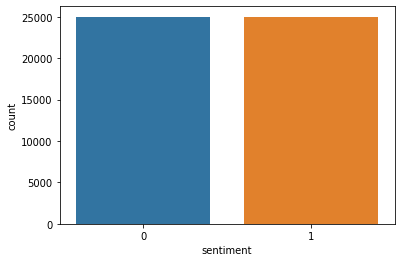

In [18]:
# Visualize class distribution (balanced or not).
sns.countplot(x='sentiment', data=movie_reviews)

### Data Preprocessing

In [19]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [20]:
def preprocess_text(sen):
  # Removing tags
  sentence = remove_tags(sen)

  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  return TAG_RE.sub('', text)

In [21]:
# Clean the data
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

#Split the data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, movie_reviews['sentiment'].values, test_size=0.20, random_state=42)

#Tokenize the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Get pre-trained embeddings (Glove)

In [23]:
# Download Glove embeddings from http://nlp.stanford.edu/data/glove.6B.zip and unzip.
wget.download("http://nlp.stanford.edu/data/glove.6B.zip")
with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
  zip_ref.extractall("./")

In [24]:
# Retrieve the embeddings and embedding matrix 
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = np.asarray(records[1:], dtype='float32')
  embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

### Simple Neural Network

In [25]:
model = Sequential()

# Create, add Embedding layer and freeze it 
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

#Flatten the embedding output 
model.add(Flatten())

model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

#Specify the optimizer, loss function and metric 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9230300   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 9,872,717
Trainable params: 642,417
Non-trainable params: 9,230,300
________________________________________

In [26]:
# Train the model by calling the fit method. Specify the batch size, number of epochs and validation (optional)
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_split=0.2)

# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 1.0749 - acc: 0.7098
Test Score: 1.0749452114105225
Test Accuracy: 0.7098000049591064


In [ ]:
#TODO: Visualize the accuracy and loss of the model using i.e matplotlib.pyplot

### Convolutional Neural Network

In [27]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9230300   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 9,294,557
Trainable params: 64,257
Non-trainable params: 9,230,300
_________________________________________________________________
None


In [28]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=0, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.3482 - acc: 0.8491
Test Score: 0.3481959104537964
Test Accuracy: 0.8490999937057495


In [49]:
def predict_sentiment(model, text, tokenizer,maxlen):
  processed_text = [preprocess_text(text)]
  text_sequences = tokenizer.texts_to_sequences(processed_text)
  padded_text = pad_sequences(text_sequences, padding='post', maxlen=maxlen)
  
  pred_sent = model.predict(padded_text)
  
  if (np.round(pred_sent) == 1.0):
    print("Positive sentiment")
  else:
    print("Negative sentiment")

In [50]:
predict_sentiment(model,"it was movie i have watched in my the last ten years", tokenizer, maxlen=maxlen)

Positive sentiment


## Lab Task
```
1. Make improvements of the current RNN by : 
  - Usin pre-trained word embeddings (GloVe)
  - different RNN architecture
  - multi-layer RNN
  - a different optimizer
2. Calculate number of model parameters (traninable and non-trainable)
3. Implement a method that will take a string (review sentence) and return a sentiment of that string

**Try to get accuracy > 80%
```

<b>Note: </b> [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) <br>
<center>Don't to forget to make a Git commit</center>